In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from scvelo package

In [2]:
adata = scv.datasets.gastrulation_erythroid()

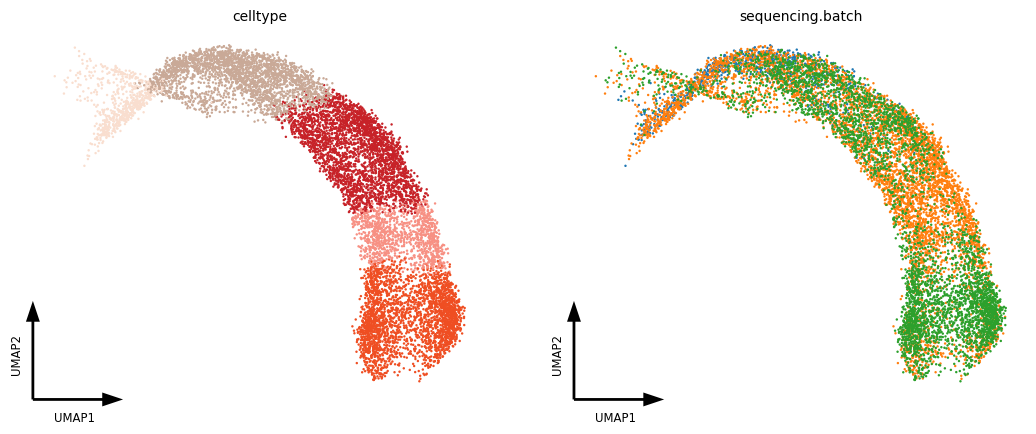

In [3]:
scv.pl.umap(adata, color=['celltype', 'sequencing.batch'], frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
adata = ltv.utils.standard_clean_recipe(adata, batch_key='sequencing.batch')

Filtered out 47456 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.VAE(observed=2000, latent_dim=20, zr_dim=1, h_dim=1,
                      batch_correction=True, batches=3)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=25, name='mouse_erythroid_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
487 velocity genes used
epoch 0, full loss 83.737, val loss 142.743, recon MSE 1.907, traj MSE 3.370, reg loss -3.636
epoch 1, full loss -233.813, val loss -213.459, recon MSE 1.747, traj MSE 2.845, reg loss -3.382
epoch 2, full loss -405.665, val loss -467.592, recon MSE 0.935, traj MSE 2.559, reg loss -3.541
epoch 3, full loss -494.114, val loss -614.755, recon MSE 0.713, traj MSE 2.495, reg loss -3.152
epoch 4, full loss -538.724, val loss -718.326, recon MSE 0.720, traj MSE 2.453, reg loss -2.500
epoch 5, full loss -538.018, val loss -793.810, recon MSE 0.664, traj MSE 2.496, reg loss -2.403
epoch 6, full loss -531.121, val loss -828.971, recon MSE 0.691, traj MSE 2.452, reg loss -2.129
epoch 7, full loss -508.470, val loss -869.307, recon MSE 0.630, traj MSE 2.498, reg loss -2.287
epoch 8, full loss -483.040, val loss -897.046, recon MSE 0.544, traj MSE 2.543, reg loss -2.326
epoch 9, full loss -468.015, val loss -

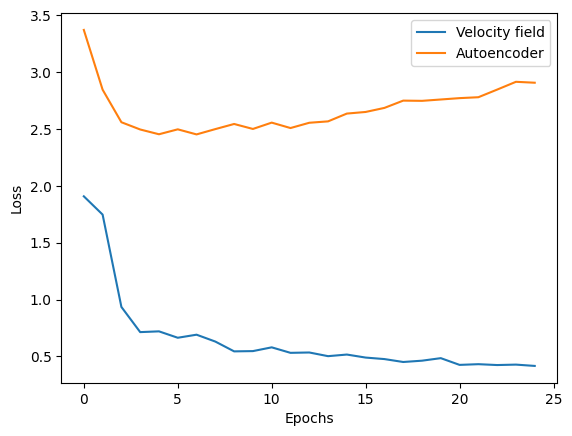

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on UMAP

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


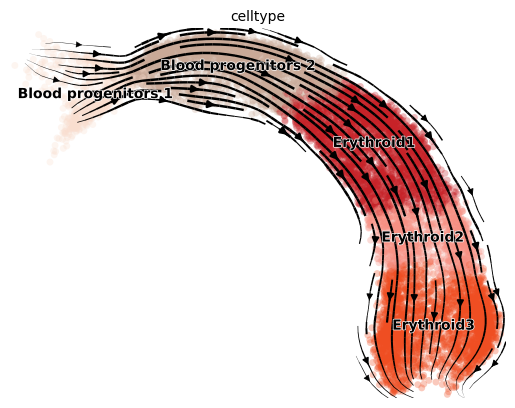

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='celltype')

In [12]:
# save fit
latent_adata.write('../benchmark/real_data/fits/erythroid_latent_adata.h5ad')

# Compute CBDir transition scores

In [11]:
erythroid_edges = [
    ('Blood progenitors 1', 'Blood progenitors 2'), 
    ('Blood progenitors 2', 'Erythroid1'),
    ('Erythroid1', 'Erythroid2'), 
    ('Erythroid2', 'Erythroid3')]

In [12]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
erythroid_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'celltype', 'spliced_velocity_pca', erythroid_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:03) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


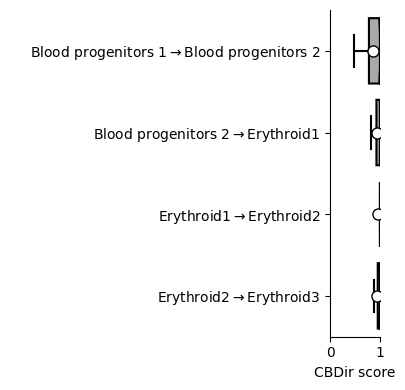

In [13]:
ax=ltv.pl.transition_scores(erythroid_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Analyze MuRK genes

Smim1, Hba-x, and Hbb-bh1 are the top predicted MuRK genes.

In [14]:
adata.var.iloc[np.argsort(-1*adata.var['R2'].values)]['MURK_gene'][:3]

index
Hba-x      True
Smim1      True
Hbb-bh1    True
Name: MURK_gene, dtype: bool

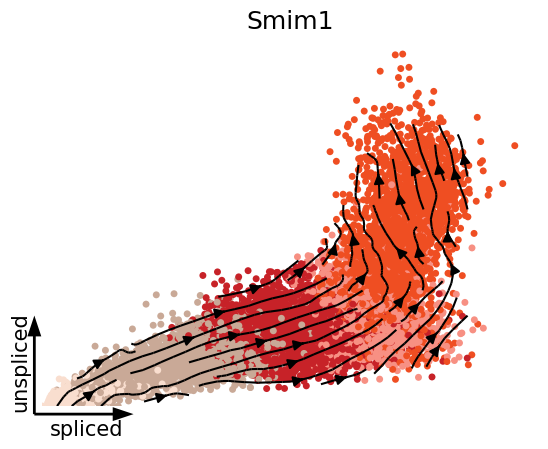

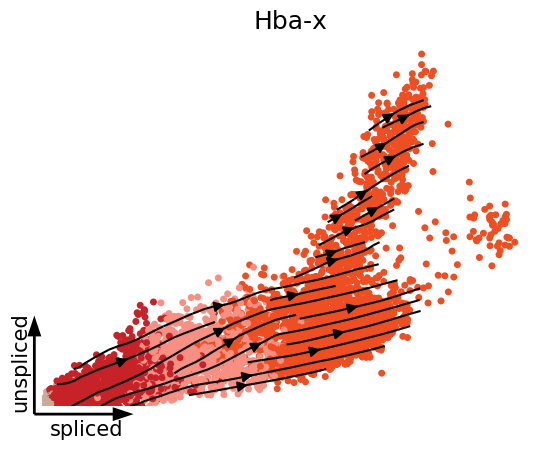

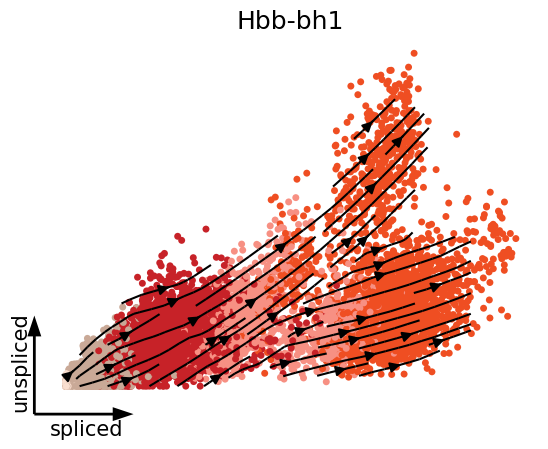

In [11]:
ltv.pl.scatter_stream(adata, 'Smim1', cluster_key='celltype')
plt.show()
ltv.pl.scatter_stream(adata, 'Hba-x', cluster_key='celltype')
plt.show()
ltv.pl.scatter_stream(adata, 'Hbb-bh1', cluster_key='celltype')
plt.show()

Weird behavior of Hbb-bh1 comes from the sequencing batches:

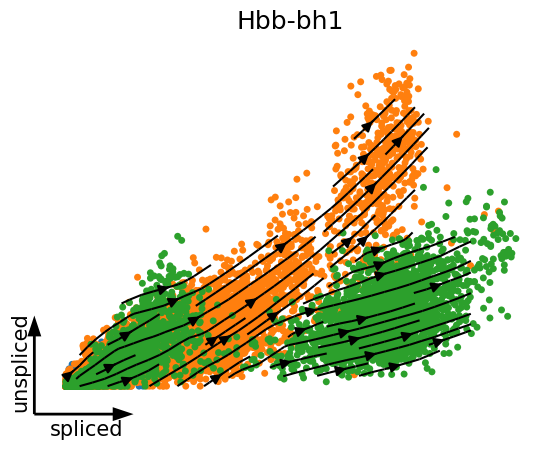

In [12]:
ltv.pl.scatter_stream(adata, 'Hbb-bh1', cluster_key='sequencing.batch')
plt.show()

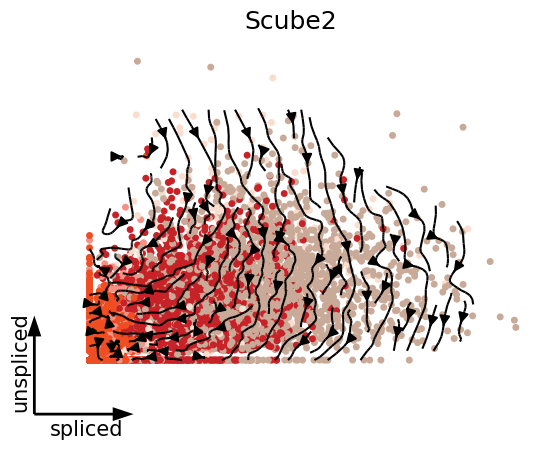

In [13]:
ltv.pl.scatter_stream(adata, 'Scube2', cluster_key='celltype')
plt.show()

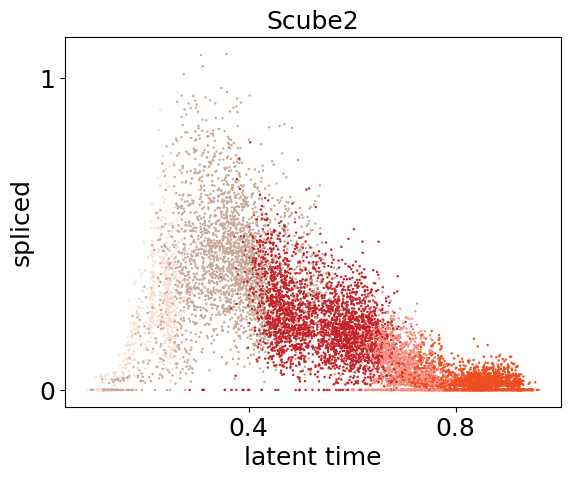

In [18]:
scv.pl.scatter(adata, x='latent_time',y='Scube2',color='celltype')

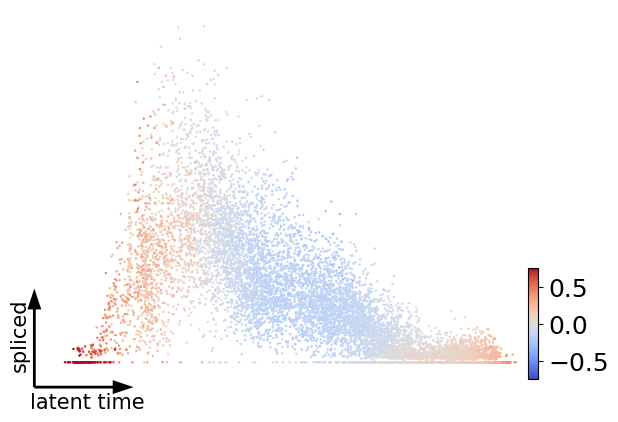

In [23]:
adata.obs['Scube2_direction'] = adata[:,adata.var.index.values=='Scube2'].layers['velo'][:,0] # > 0
scv.pl.scatter(adata, x='latent_time', y='Scube2', color='Scube2_direction', color_map='coolwarm',
              title='', vmin=-0.75, vmax=0.75, frameon='artist')